In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from xgboost import XGBRFClassifier, XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from imblearn.over_sampling import SMOTE
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
import warnings
warnings.filterwarnings(action='ignore')

### Read Data

In [2]:
df = pd.read_csv('train.csv')
df.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,...,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,0,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,31.277,87.009,...,0,0,NaN,NaN,NaN,1958,0.0,0.0,0.0,0
1,1,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.000,122.787,...,0,0,NaN,1.0,NaN,710,0.0,0.0,0.0,0
2,2,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,60.806,103.176,...,0,0,NaN,NaN,NaN,882,0.0,0.0,0.0,0
3,3,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,156.362,205.260,...,0,0,NaN,NaN,NaN,982,0.0,0.0,0.0,0
4,4,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,240.708,128.191,...,1,0,1.0,1.0,1.0,647,0.0,0.0,0.0,0


In [3]:
df.shape

(69999, 172)

In [4]:
print(df.dtypes[:60], df.dtypes[60:120], df.dtypes[120:])

id                        int64
circle_id                 int64
loc_og_t2o_mou          float64
std_og_t2o_mou          float64
loc_ic_t2o_mou          float64
last_date_of_month_6     object
last_date_of_month_7     object
last_date_of_month_8     object
arpu_6                  float64
arpu_7                  float64
arpu_8                  float64
onnet_mou_6             float64
onnet_mou_7             float64
onnet_mou_8             float64
offnet_mou_6            float64
offnet_mou_7            float64
offnet_mou_8            float64
roam_ic_mou_6           float64
roam_ic_mou_7           float64
roam_ic_mou_8           float64
roam_og_mou_6           float64
roam_og_mou_7           float64
roam_og_mou_8           float64
loc_og_t2t_mou_6        float64
loc_og_t2t_mou_7        float64
loc_og_t2t_mou_8        float64
loc_og_t2m_mou_6        float64
loc_og_t2m_mou_7        float64
loc_og_t2m_mou_8        float64
loc_og_t2f_mou_6        float64
loc_og_t2f_mou_7        float64
loc_og_t

### Remove columns having more than 70% null values

In [5]:
columns_70 = []
for col in df.columns:
    print(col, '<--------->', df[col].isna().sum(),'<--------->', round((df[col].isna().sum()/69999)*100,2))
    if round((df[col].isna().sum()/69999)*100,2) < 70:
        columns_70.append(col)
df = df[columns_70]

id <---------> 0 <---------> 0.0
circle_id <---------> 0 <---------> 0.0
loc_og_t2o_mou <---------> 702 <---------> 1.0
std_og_t2o_mou <---------> 702 <---------> 1.0
loc_ic_t2o_mou <---------> 702 <---------> 1.0
last_date_of_month_6 <---------> 0 <---------> 0.0
last_date_of_month_7 <---------> 399 <---------> 0.57
last_date_of_month_8 <---------> 733 <---------> 1.05
arpu_6 <---------> 0 <---------> 0.0
arpu_7 <---------> 0 <---------> 0.0
arpu_8 <---------> 0 <---------> 0.0
onnet_mou_6 <---------> 2768 <---------> 3.95
onnet_mou_7 <---------> 2687 <---------> 3.84
onnet_mou_8 <---------> 3703 <---------> 5.29
offnet_mou_6 <---------> 2768 <---------> 3.95
offnet_mou_7 <---------> 2687 <---------> 3.84
offnet_mou_8 <---------> 3703 <---------> 5.29
roam_ic_mou_6 <---------> 2768 <---------> 3.95
roam_ic_mou_7 <---------> 2687 <---------> 3.84
roam_ic_mou_8 <---------> 3703 <---------> 5.29
roam_og_mou_6 <---------> 2768 <---------> 3.95
roam_og_mou_7 <---------> 2687 <---------> 3.

### Null Value Treatment

In [6]:
#Check columns with null values
for col in df.columns:
    if round((df[col].isna().sum()/69999)*100,2) > 0:
        print(col, '<--------->', df[col].isna().sum(),'<--------->', round((df[col].isna().sum()/69999)*100,2),'%')

loc_og_t2o_mou <---------> 702 <---------> 1.0 %
std_og_t2o_mou <---------> 702 <---------> 1.0 %
loc_ic_t2o_mou <---------> 702 <---------> 1.0 %
last_date_of_month_7 <---------> 399 <---------> 0.57 %
last_date_of_month_8 <---------> 733 <---------> 1.05 %
onnet_mou_6 <---------> 2768 <---------> 3.95 %
onnet_mou_7 <---------> 2687 <---------> 3.84 %
onnet_mou_8 <---------> 3703 <---------> 5.29 %
offnet_mou_6 <---------> 2768 <---------> 3.95 %
offnet_mou_7 <---------> 2687 <---------> 3.84 %
offnet_mou_8 <---------> 3703 <---------> 5.29 %
roam_ic_mou_6 <---------> 2768 <---------> 3.95 %
roam_ic_mou_7 <---------> 2687 <---------> 3.84 %
roam_ic_mou_8 <---------> 3703 <---------> 5.29 %
roam_og_mou_6 <---------> 2768 <---------> 3.95 %
roam_og_mou_7 <---------> 2687 <---------> 3.84 %
roam_og_mou_8 <---------> 3703 <---------> 5.29 %
loc_og_t2t_mou_6 <---------> 2768 <---------> 3.95 %
loc_og_t2t_mou_7 <---------> 2687 <---------> 3.84 %
loc_og_t2t_mou_8 <---------> 3703 <---------

In [7]:
# Delete Date columns
date_col = []
for col in df.columns:
    if 'date' in col:
        date_col.append(col)
df.drop(columns=date_col, inplace=True)

In [8]:
#Fill MOU and other outgoing, incoming call null values with 0
df.fillna(0, inplace=True)

In [9]:
df.isna().sum()

id                   0
circle_id            0
loc_og_t2o_mou       0
std_og_t2o_mou       0
loc_ic_t2o_mou       0
                    ..
aon                  0
aug_vbc_3g           0
jul_vbc_3g           0
jun_vbc_3g           0
churn_probability    0
Length: 136, dtype: int64

### Feature Engineering

In [10]:
#find all the month columns
month_col = []
distinct_features = []
for col in df.columns:
    if '6' in col or '7' in col or '8' in col:
        month_col.append(col)
        col = col.split('_')[:-1]
        col = '_'.join(col)
        distinct_features.append(col)
        
df[month_col]

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,...,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8
0,31.277,87.009,7.527,48.58,124.38,1.29,32.24,96.68,2.33,0.00,...,0,0,0,0,0,0,0,0,0,0
1,0.000,122.787,42.953,0.00,0.00,0.00,0.00,25.99,30.89,0.00,...,0,0,0,0,0,1,0,0,0,0
2,60.806,103.176,0.000,0.53,15.93,0.00,53.99,82.05,0.00,0.00,...,0,0,0,0,0,0,0,0,0,0
3,156.362,205.260,111.095,7.26,16.01,0.00,68.76,78.48,50.23,0.00,...,0,0,0,0,0,0,0,0,0,0
4,240.708,128.191,101.565,21.28,4.83,6.13,56.99,38.11,9.63,53.64,...,0,7,6,6,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69994,15.760,410.924,329.136,0.00,7.36,10.93,0.00,488.46,381.64,14.96,...,0,0,6,1,0,0,0,0,1,0
69995,160.083,289.129,265.772,116.54,196.46,232.63,49.53,96.28,48.06,0.00,...,0,0,0,0,0,0,0,0,0,0
69996,372.088,258.374,279.782,77.13,68.44,78.44,335.54,227.94,263.84,0.00,...,0,0,0,0,0,0,0,0,0,0
69997,238.575,245.414,145.062,14.01,7.64,6.71,30.34,16.68,12.56,25.06,...,0,0,0,0,1,1,1,0,0,0


In [11]:
df.shape

(69999, 136)

In [12]:
# Find the avg and difference for all these columns
for feature in set(distinct_features):
    df[feature+'_avg'] = (df[feature+'_6'] + df[feature+'_7'])/2
    df[feature+'_diff'] = df[feature+'_avg'] - df[feature+'_8']
    df.drop(columns=[feature+'_6', feature+'_7', feature+'_8'], inplace=True)

In [13]:
df['vbc_3g_avg'] = df['jun_vbc_3g'] + df['jul_vbc_3g']
df['vbc_3g_avg'] = df['vbc_3g_avg']/2
df['vbc_3g_diff'] = df['vbc_3g_avg'] - df['aug_vbc_3g']
df.drop(columns=['aug_vbc_3g', 'jun_vbc_3g', 'jul_vbc_3g'], inplace=True)

In [14]:
df.iloc[:, 10:].head()

,loc_ic_t2t_mou_diff,loc_ic_t2m_mou_avg,loc_ic_t2m_mou_diff,total_rech_amt_avg,total_rech_amt_diff,std_og_t2f_mou_avg,std_og_t2f_mou_diff,onnet_mou_avg,onnet_mou_diff,std_ic_t2t_mou_avg,...,std_og_mou_avg,std_og_mou_diff,sachet_3g_avg,sachet_3g_diff,std_ic_t2o_mou_avg,std_ic_t2o_mou_diff,vol_3g_mb_avg,vol_3g_mb_diff,vbc_3g_avg,vbc_3g_diff
0,-4.735,10.955,-5.955,71.0,61.0,0.00,0.00,86.480,85.190,3.805,...,135.040,134.030,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0
1,-0.145,10.045,-1.045,72.5,22.5,0.00,0.00,0.000,0.000,0.000,...,0.000,0.000,0.0,0.0,0.0,0.0,1.98,1.98,0.0,0.0
2,-1.155,57.520,34.010,95.0,95.0,0.00,0.00,8.230,8.230,5.845,...,56.965,56.965,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0
3,-8.970,49.110,-8.030,200.0,70.0,0.28,0.28,11.635,11.635,0.000,...,27.075,22.475,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0
4,0.755,7.455,-12.035,213.0,91.0,0.00,0.00,13.055,6.925,0.000,...,2.175,2.175,0.5,0.5,0.0,0.0,0.00,0.00,0.0,0.0


### EDA

#### Univariate

###### Delete the columns with 0 variance

id std: 20207.11508355411
circle_id std: 0.0
loc_og_t2o_mou std: 0.0
std_og_t2o_mou std: 0.0
loc_ic_t2o_mou std: 0.0
aon std: 952.426320924281
churn_probability std: 0.30250203588069513
sachet_2g_avg std: 1.4533745515850425
sachet_2g_diff std: 1.2213479279210273
loc_ic_t2t_mou_avg std: 132.9801258022271
loc_ic_t2t_mou_diff std: 90.15434126736353
loc_ic_t2m_mou_avg std: 155.49109651814584
loc_ic_t2m_mou_diff std: 106.7794154295554
total_rech_amt_avg std: 376.1726527635654
total_rech_amt_diff std: 291.95102090497426
std_og_t2f_mou_avg std: 7.326342508951085
std_og_t2f_mou_diff std: 5.527659733163842
onnet_mou_avg std: 279.960557401265
onnet_mou_diff std: 210.2898005861384
std_ic_t2t_mou_avg std: 48.680804853974486
std_ic_t2t_mou_diff std: 43.33476994193299
std_ic_mou_avg std: 99.32261887033899
std_ic_mou_diff std: 76.51104985868459
loc_og_t2t_mou_avg std: 142.04177483079602
loc_og_t2t_mou_diff std: 92.33311513114951
max_rech_amt_avg std: 104.05660123988072
max_rech_amt_diff std: 103.9808

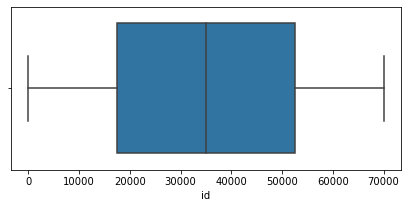

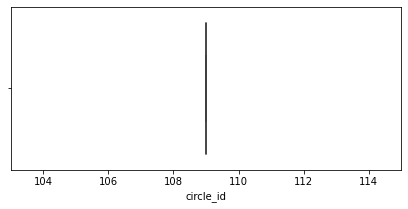

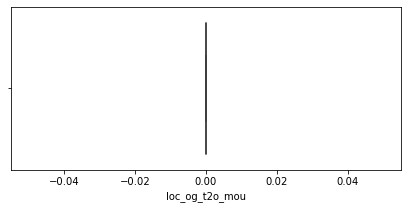

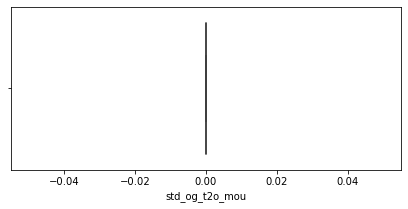

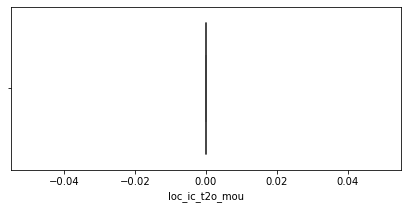

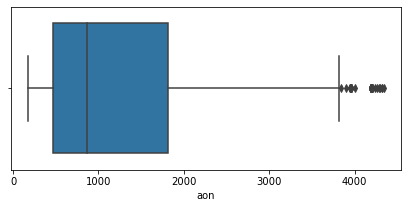

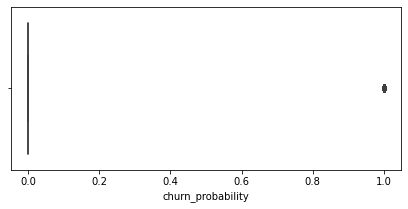

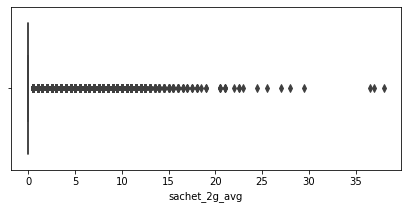

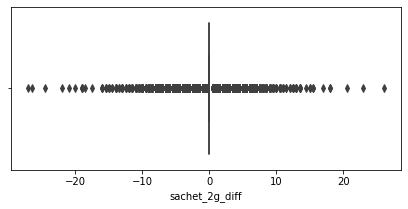

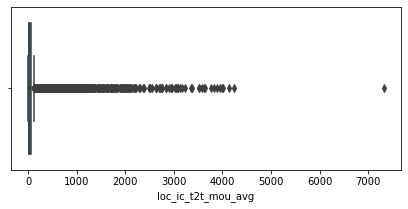

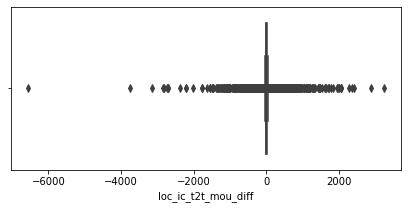

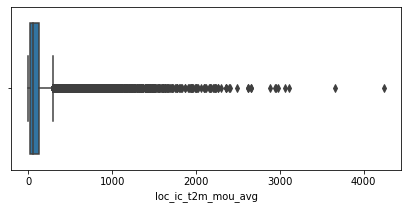

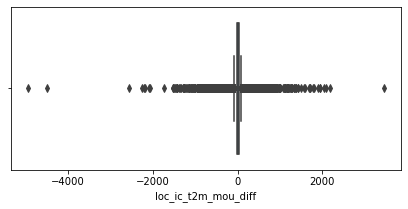

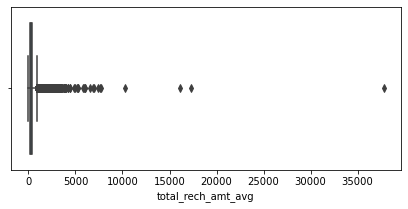

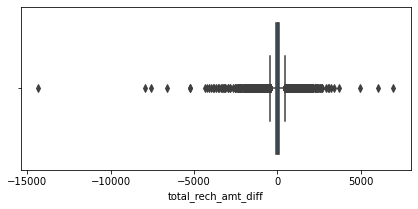

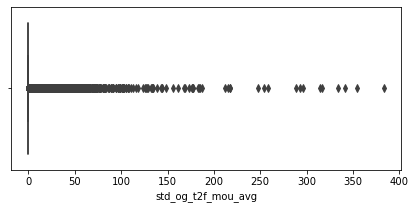

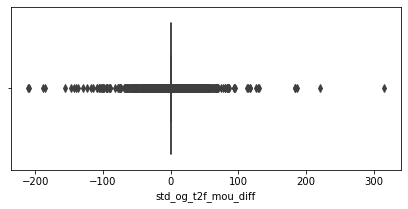

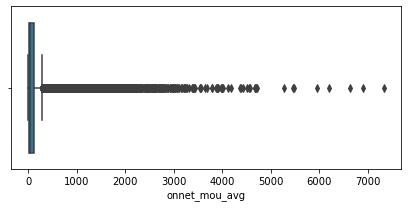

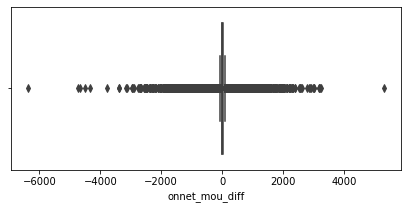

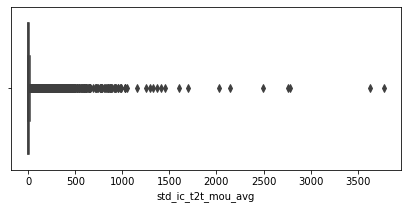

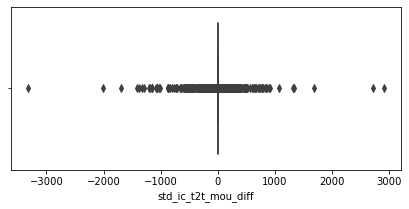

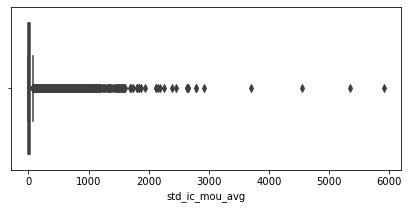

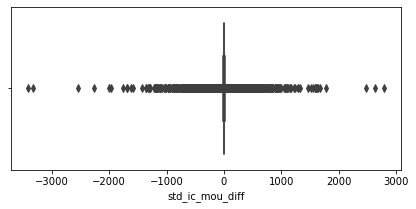

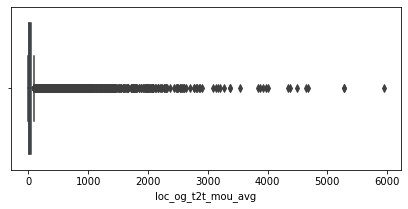

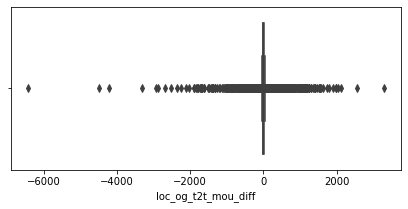

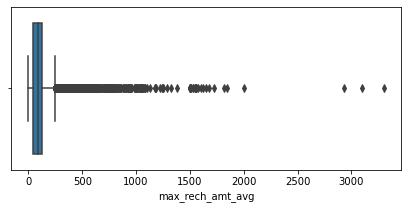

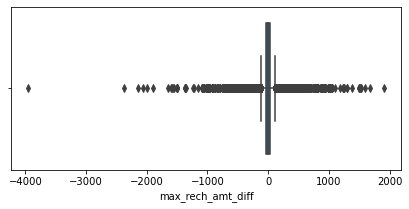

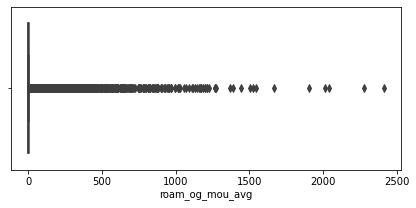

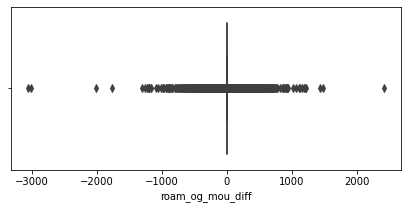

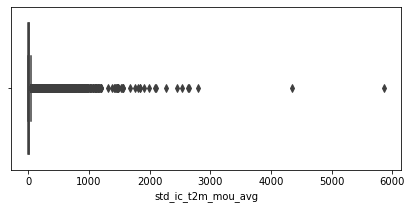

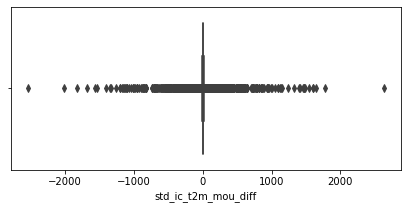

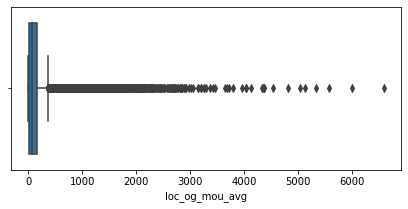

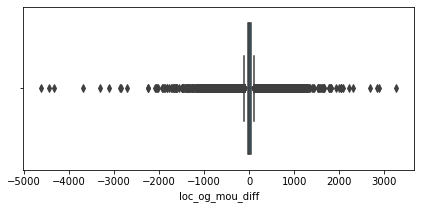

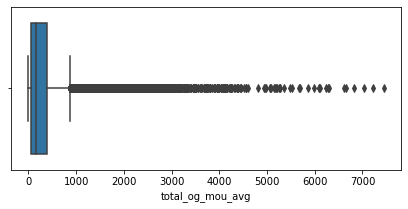

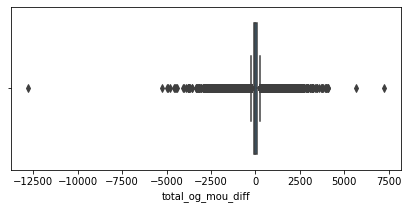

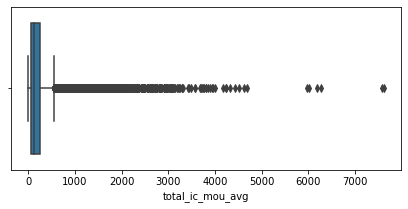

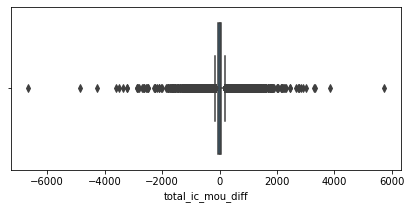

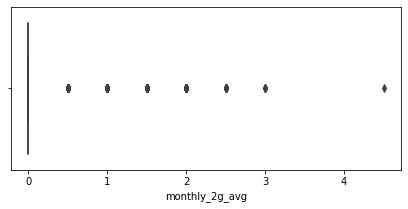

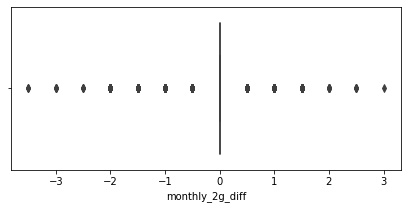

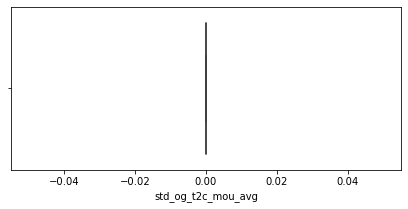

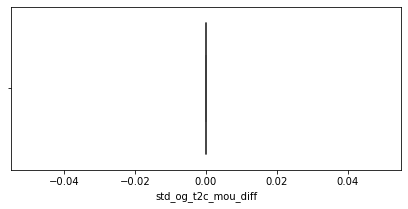

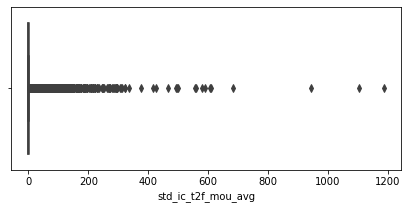

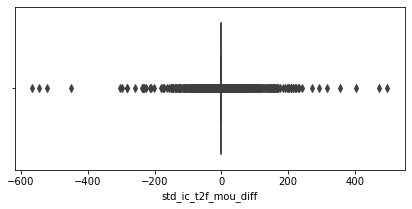

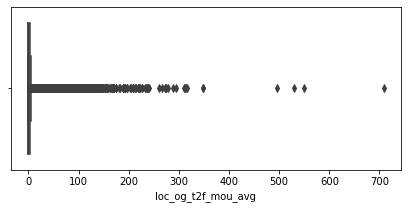

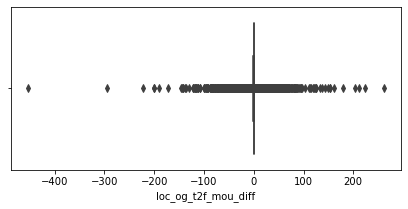

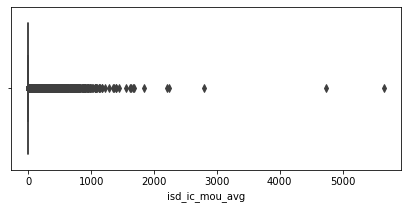

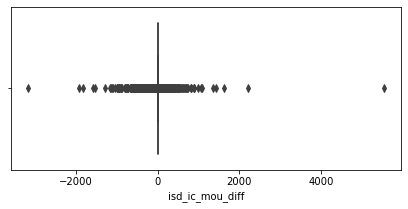

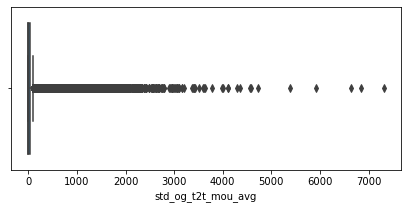

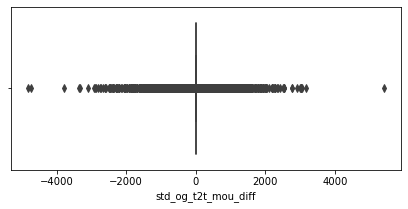

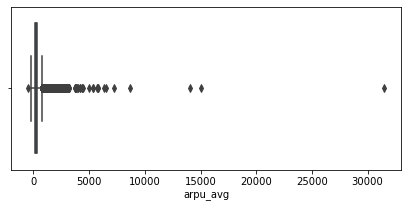

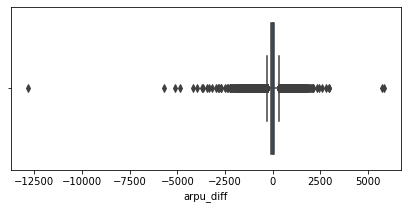

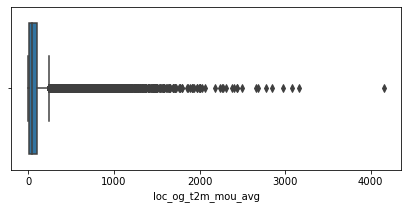

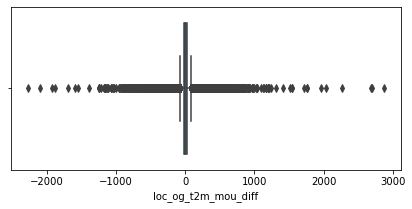

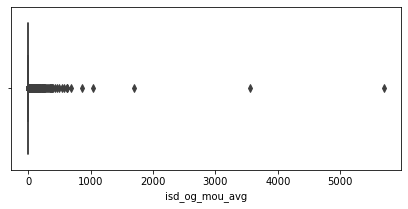

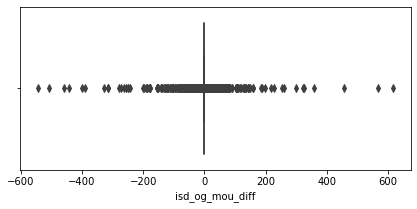

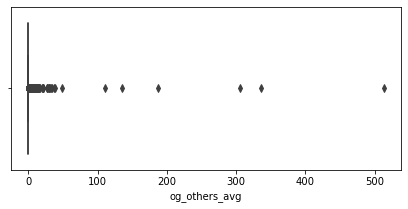

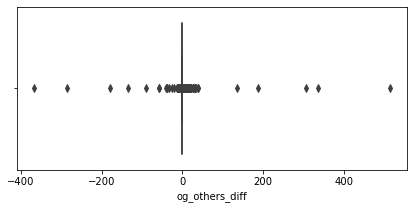

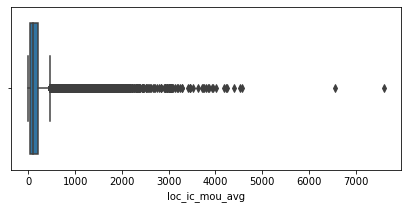

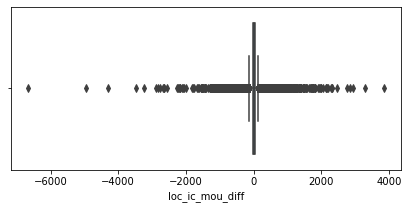

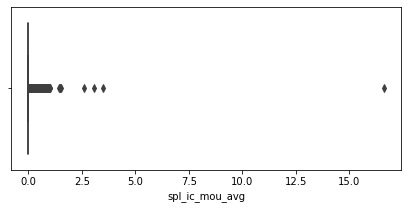

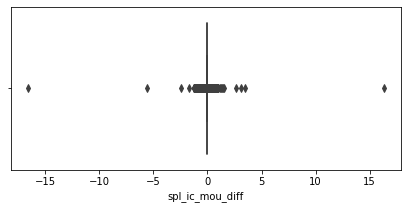

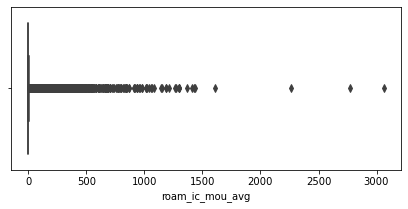

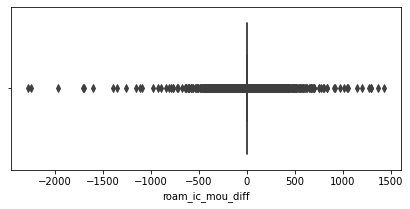

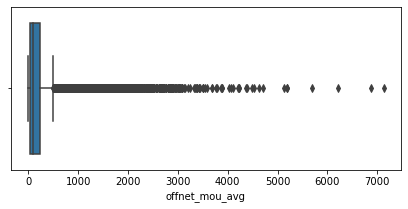

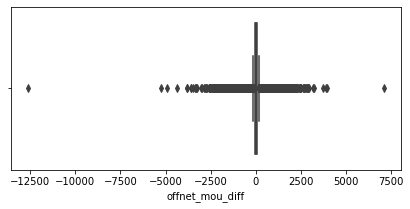

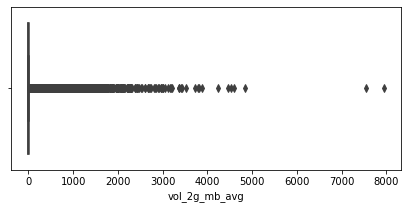

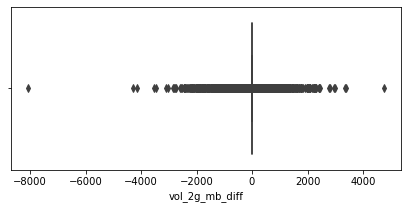

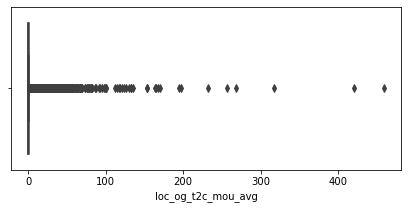

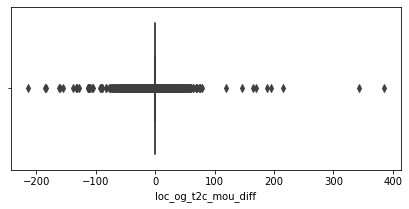

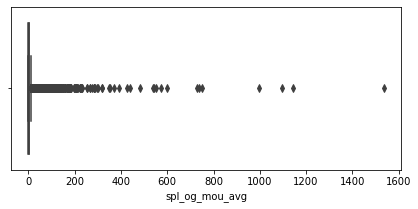

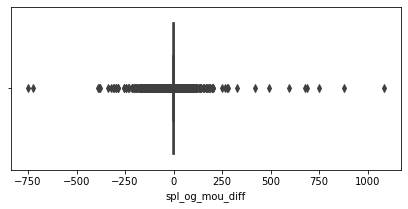

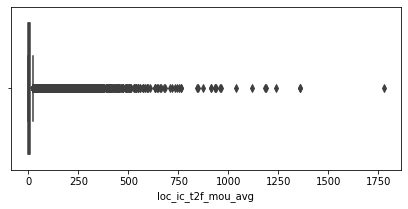

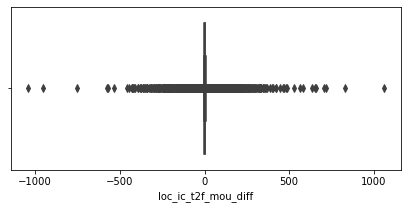

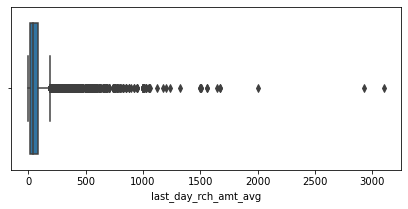

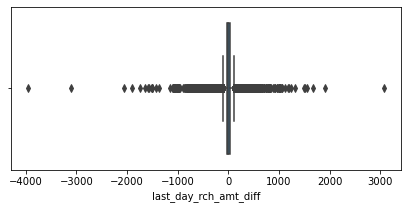

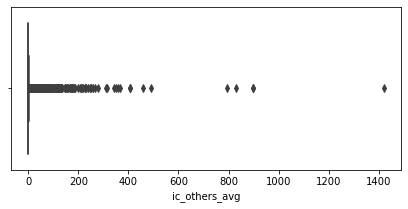

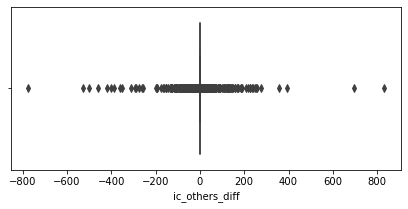

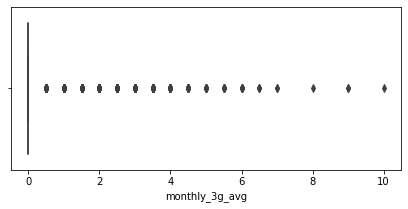

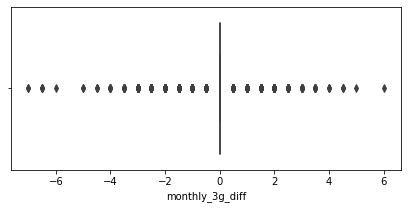

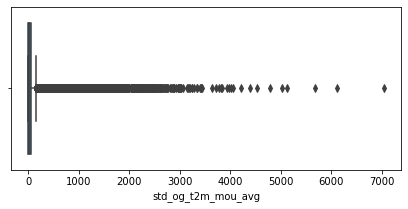

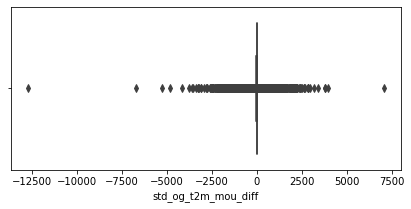

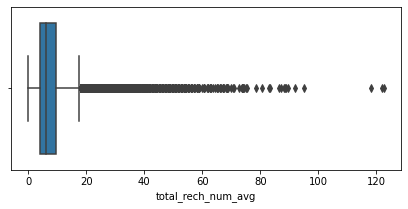

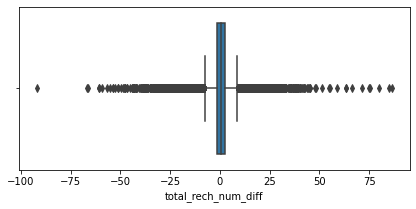

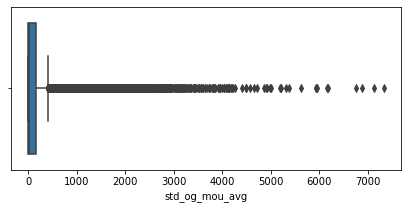

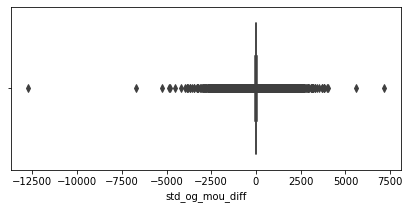

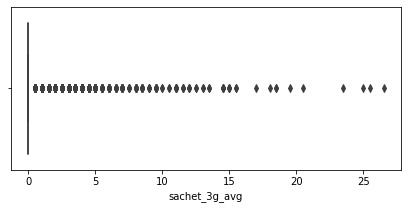

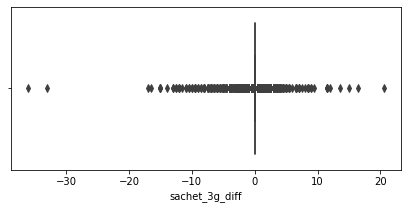

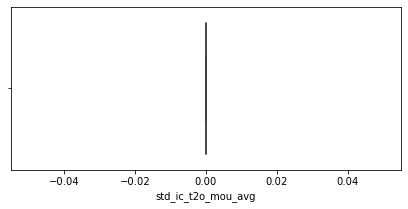

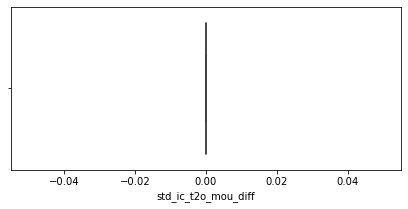

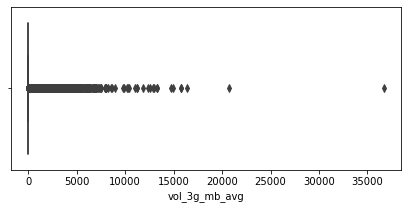

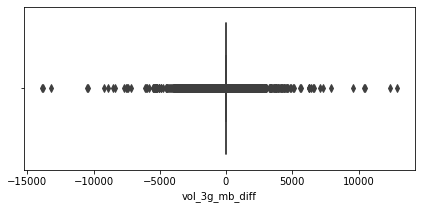

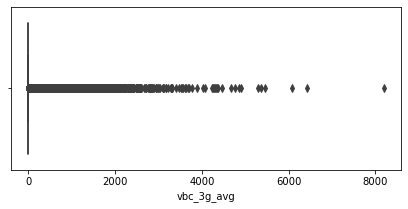

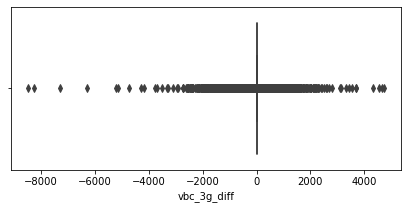

In [15]:
cols_with_std_0 = []
for col in df.columns:
    plt.figure(figsize=(7,3))
    sns.boxplot(x=col, data=df)
    print(col,'std:', df[col].std())
    if df[col].std() == 0:
        cols_with_std_0.append(col)
df.drop(columns=cols_with_std_0, inplace=True)

In [16]:
outlier_columns = ['aon', 'std_og_mou_avg', 'last_day_rch_amt_avg', 'onnet_mou_avg', 'loc_ic_mou_avg', 'loc_og_mou_avg', 'max_rech_amt_avg', 'loc_ic_t2m_mou_avg', 'loc_og_t2m_mou_avg', 'offnet_mou_avg', 'total_rech_num_avg', 'total_ic_mou_avg', 'total_og_mou_avg']
for col in outlier_columns:
    if col != 'churn_probability'  and 'diff' not in col :
        iqr = df[col].quantile(0.75) - df[col].quantile(0.25)
        uqr = df[col].quantile(0.75) + (iqr*1.5)
        lqr = df[col].quantile(0.25) - (iqr*1.5)
        df = df[(df[col] >=lqr) & (df[col] <= uqr)]
        print(col, '-->', df.shape)

aon --> (69938, 85)
std_og_mou_avg --> (60801, 85)
last_day_rch_amt_avg --> (57789, 85)
onnet_mou_avg --> (52222, 85)
loc_ic_mou_avg --> (48719, 85)
loc_og_mou_avg --> (45660, 85)
max_rech_amt_avg --> (44353, 85)
loc_ic_t2m_mou_avg --> (42280, 85)
loc_og_t2m_mou_avg --> (40267, 85)
offnet_mou_avg --> (37902, 85)
total_rech_num_avg --> (35991, 85)
total_ic_mou_avg --> (34670, 85)
total_og_mou_avg --> (34217, 85)


In [17]:
df.iloc[:, :15].describe()

,id,aon,churn_probability,sachet_2g_avg,sachet_2g_diff,loc_ic_t2t_mou_avg,loc_ic_t2t_mou_diff,loc_ic_t2m_mou_avg,loc_ic_t2m_mou_diff,total_rech_amt_avg,total_rech_amt_diff,std_og_t2f_mou_avg,std_og_t2f_mou_diff,onnet_mou_avg,onnet_mou_diff
count,34217.000000,34217.000000,34217.000000,34217.000000,34217.000000,34217.000000,34217.000000,34217.000000,34217.000000,34217.000000,34217.000000,34217.000000,34217.000000,34217.000000,34217.000000
mean,35027.529737,1176.613818,0.115440,0.312242,-0.032937,20.152984,-2.434349,47.987946,-7.977942,141.581758,-40.735775,0.611879,-0.034025,29.089496,-15.896423
std,20218.185549,929.867076,0.319556,1.047036,1.072367,30.977680,36.281781,47.803341,61.244729,103.990412,201.460000,3.962881,4.028343,37.257459,109.475637
min,0.000000,180.000000,0.000000,0.000000,-27.000000,0.000000,-1245.855000,0.000000,-2091.225000,0.000000,-7917.000000,0.000000,-188.570000,0.000000,-4339.915000
25%,17487.000000,451.000000,0.000000,0.000000,0.000000,1.420000,-5.970000,9.135000,-19.465000,70.500000,-105.000000,0.000000,0.000000,2.975000,-11.305000
50%,35030.000000,828.000000,0.000000,0.000000,0.000000,8.605000,0.000000,33.475000,0.000000,122.500000,-10.000000,0.000000,0.000000,14.265000,0.000000
75%,52703.000000,1706.000000,0.000000,0.000000,0.000000,25.235000,5.590000,73.035000,13.450000,190.000000,69.500000,0.000000,0.000000,40.040000,9.335000
max,69998.000000,3821.000000,1.000000,12.000000,9.000000,312.055000,294.645000,213.585000,212.550000,1349.500000,1132.500000,184.780000,83.850000,184.670000,183.955000


### Bivariate Analysis

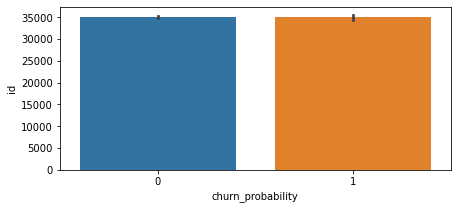

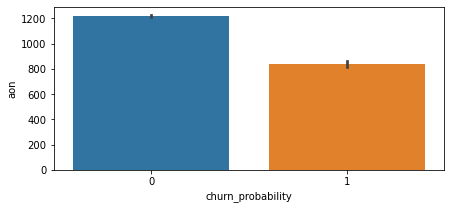

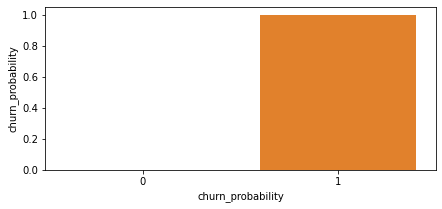

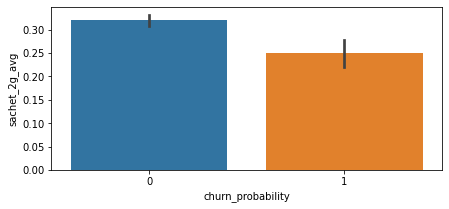

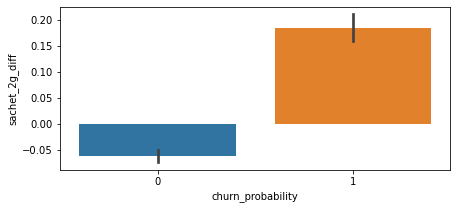

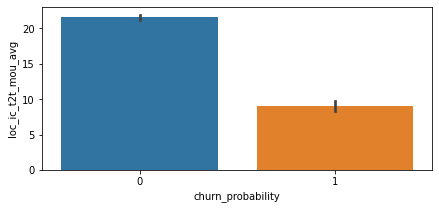

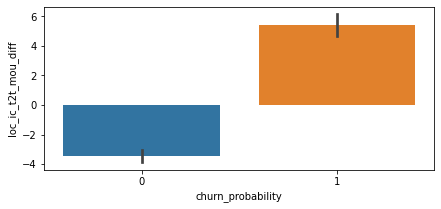

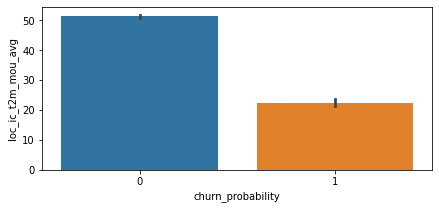

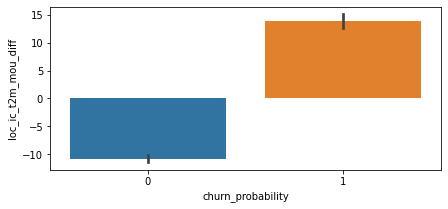

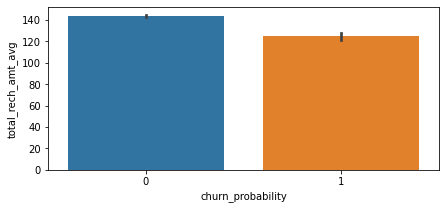

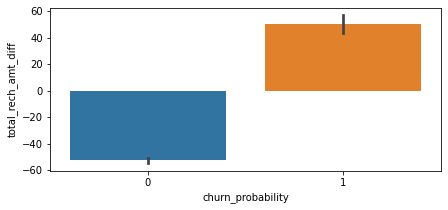

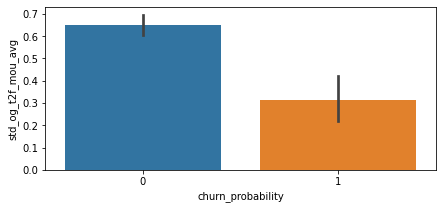

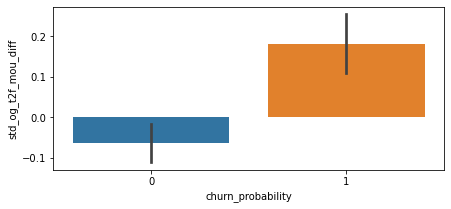

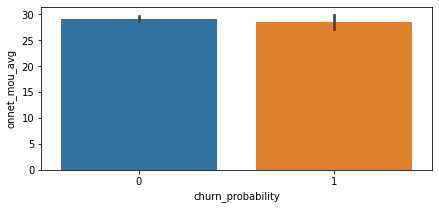

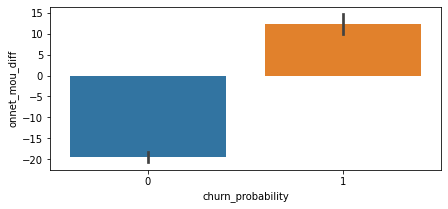

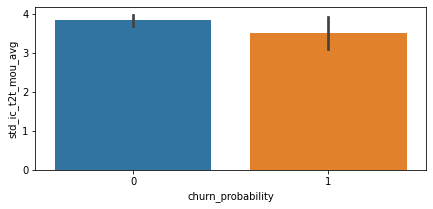

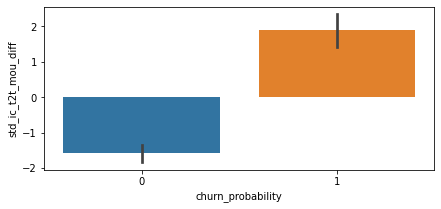

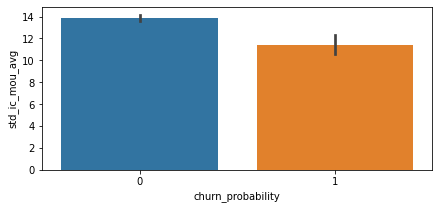

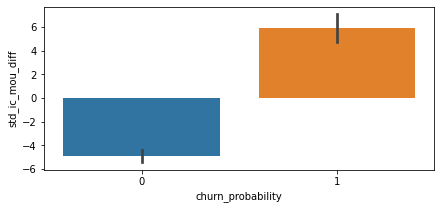

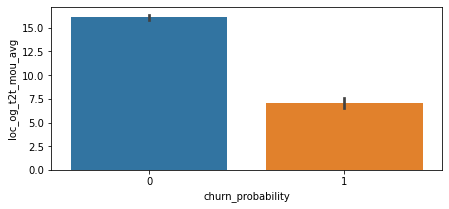

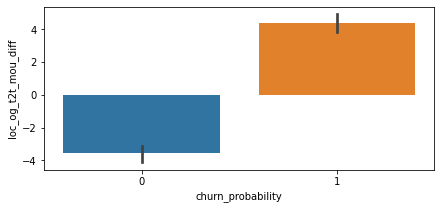

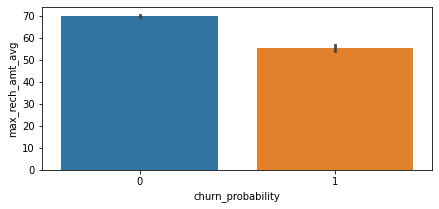

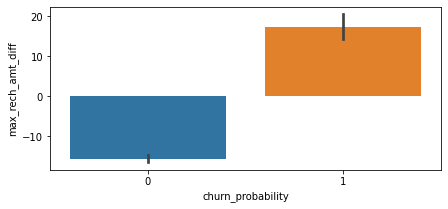

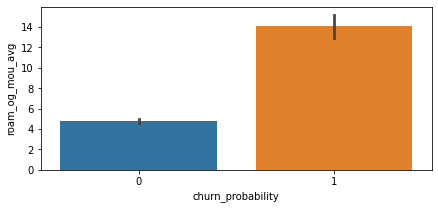

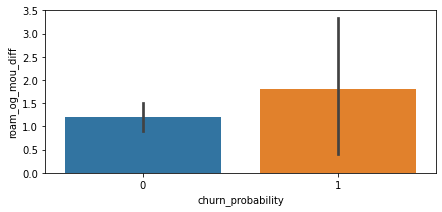

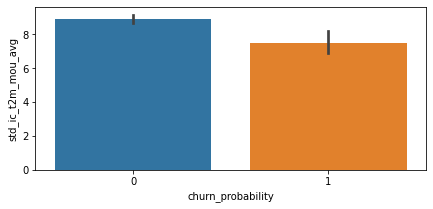

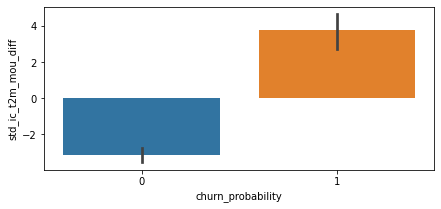

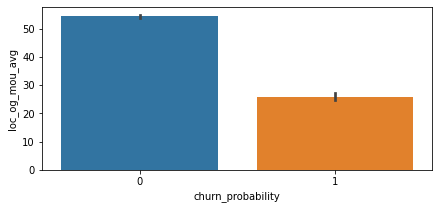

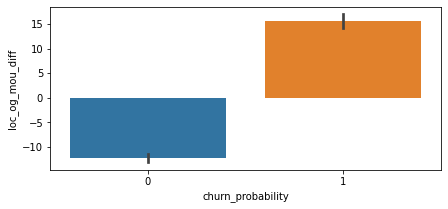

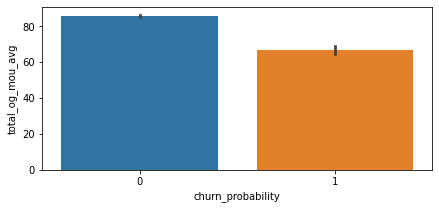

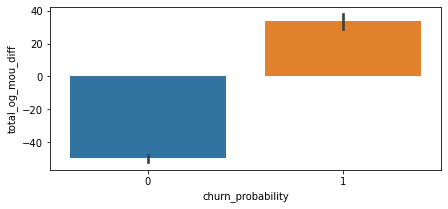

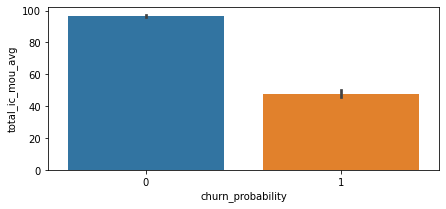

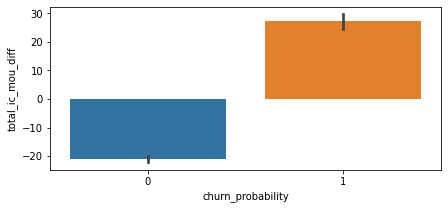

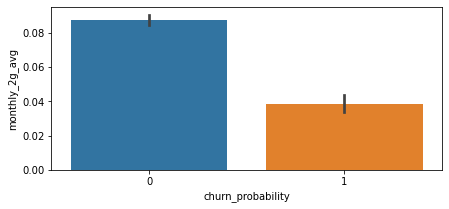

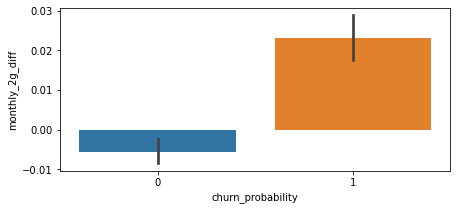

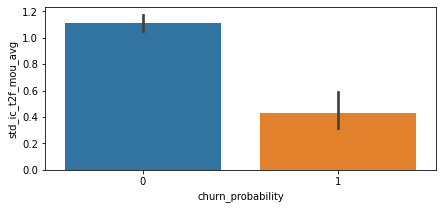

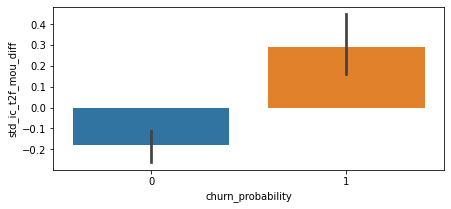

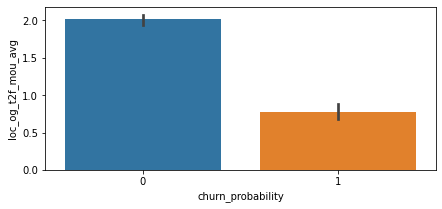

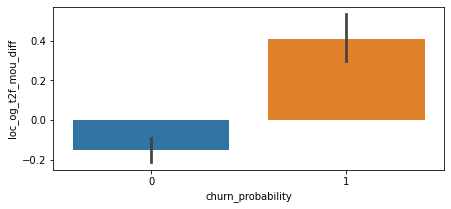

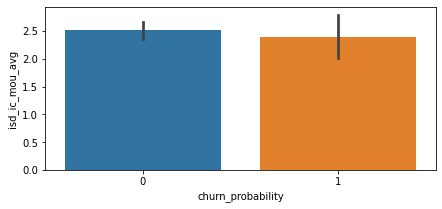

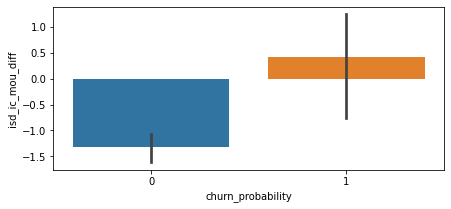

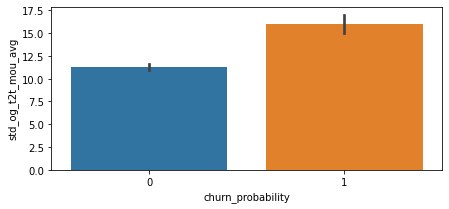

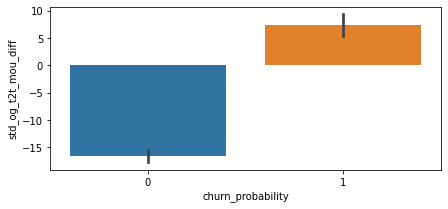

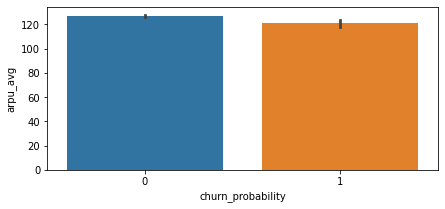

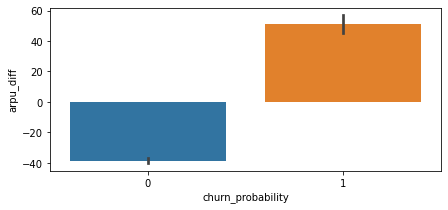

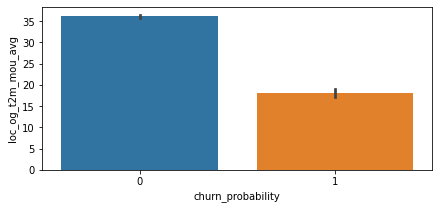

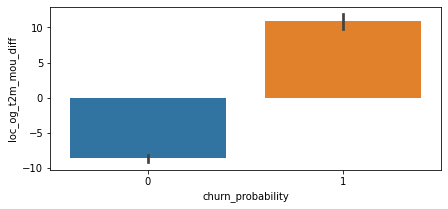

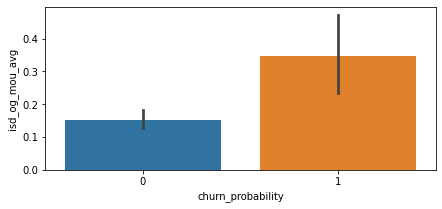

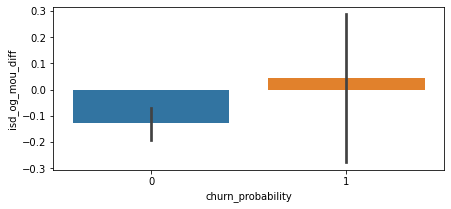

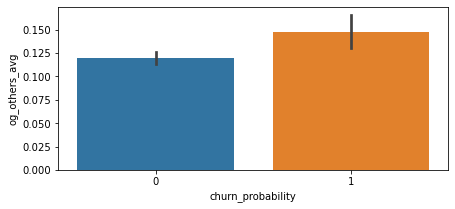

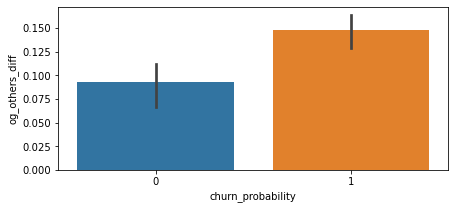

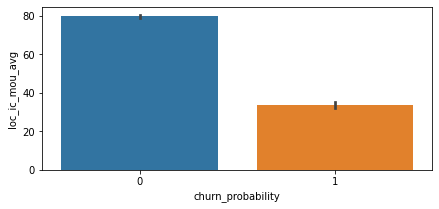

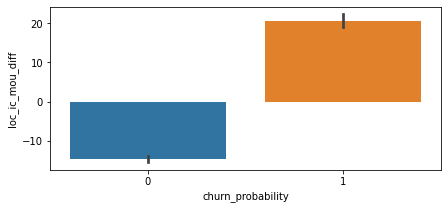

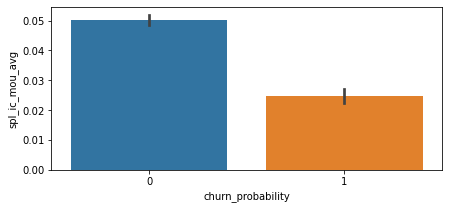

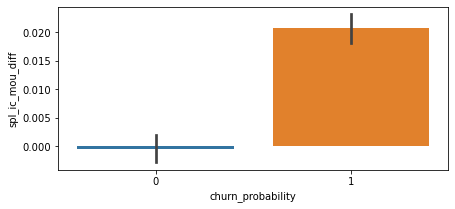

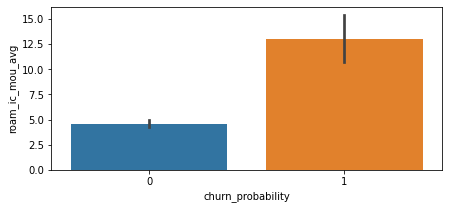

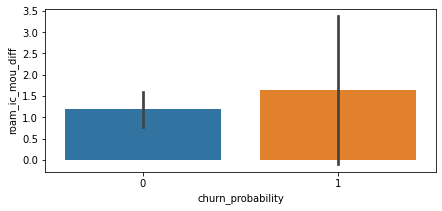

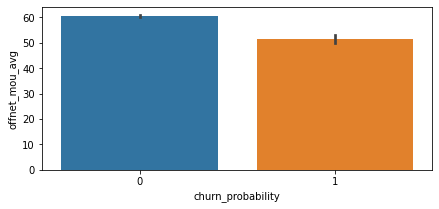

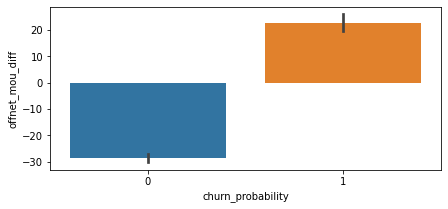

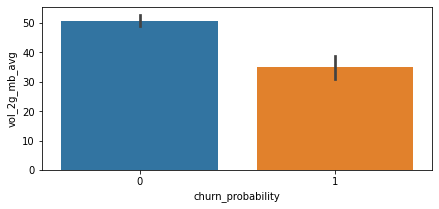

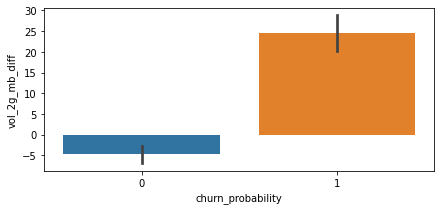

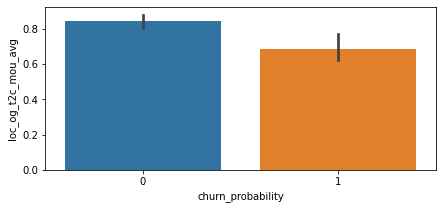

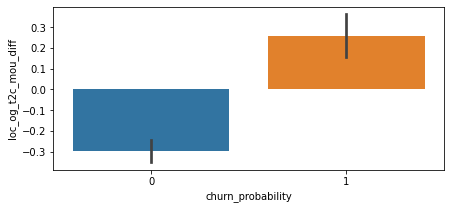

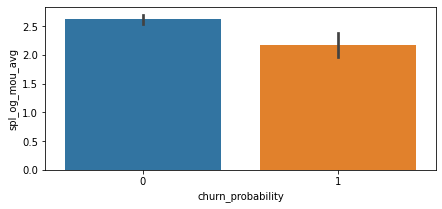

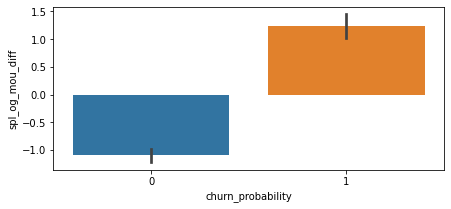

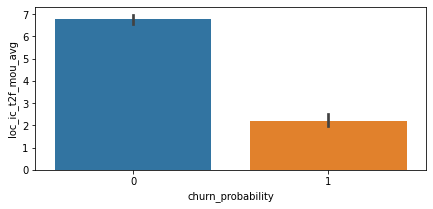

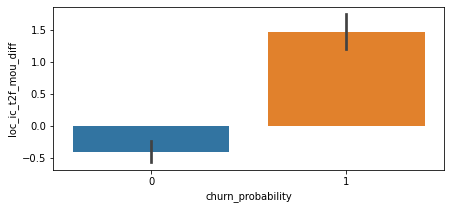

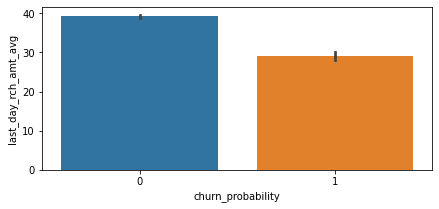

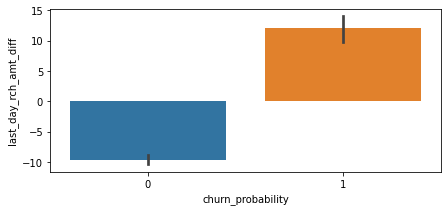

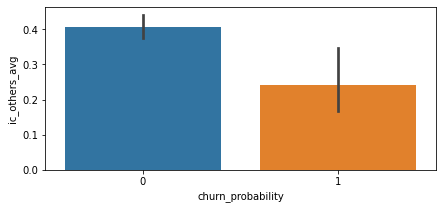

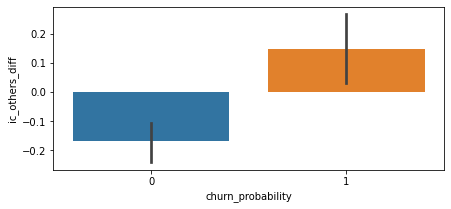

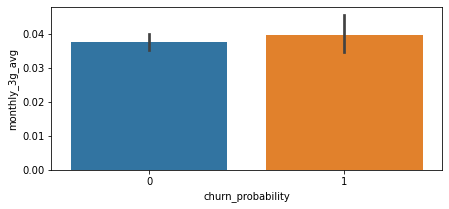

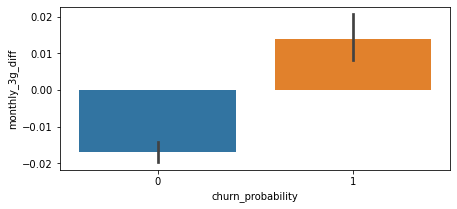

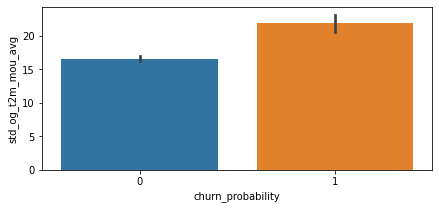

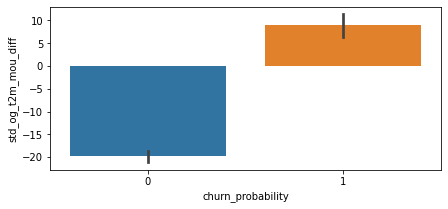

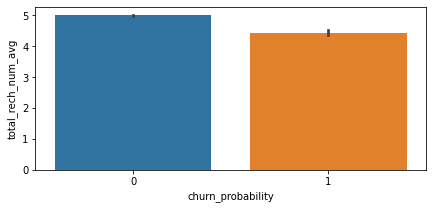

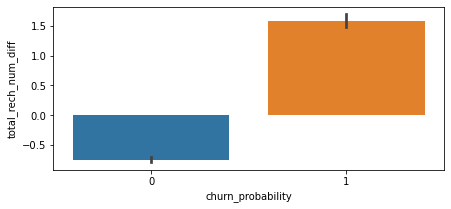

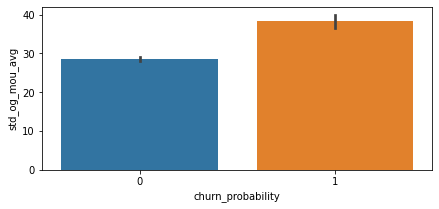

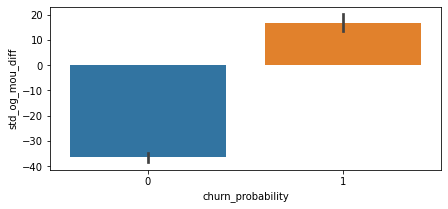

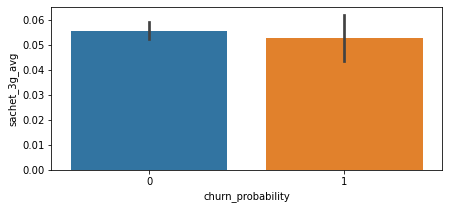

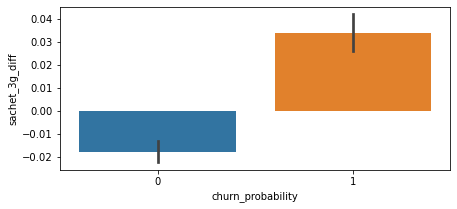

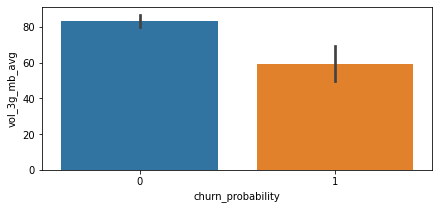

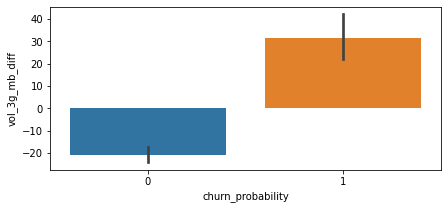

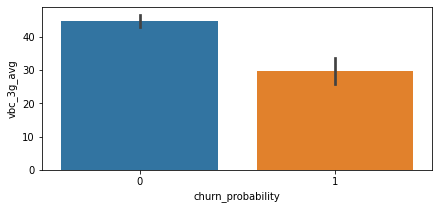

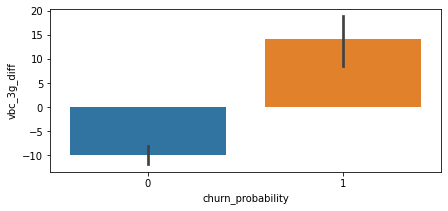

In [18]:
for col in df.columns:
    plt.figure(figsize=(7,3))
    sns.barplot(x='churn_probability',y=col, data=df)

#### From Above chart we understood
1. Newer customers are very likely churn compared to older customers. Newer customer's average age around 800days
2. We can see non churn customer usaage are high compared churn.
3. Difference between avg usage and last month usage is high for churned customers

### Handling Imbalance Data

<AxesSubplot:xlabel='churn_probability', ylabel='count'>

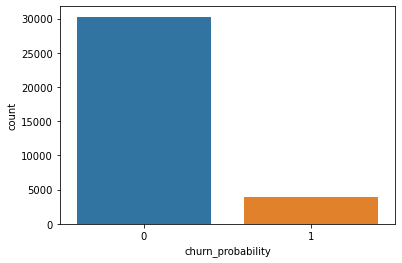

In [19]:
sns.countplot(x='churn_probability', data=df)

In [20]:
df['churn_probability'].value_counts()

0    30267
1     3950
Name: churn_probability, dtype: int64

In [21]:
new_df = df.copy()

In [22]:
y = new_df.loc[:, ['churn_probability']]
new_df.drop(columns=['churn_probability'], inplace=True)

In [23]:
smote = SMOTE(random_state = 2)
new_df, y = smote.fit_resample(new_df, y)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(new_df, y, random_state=42, test_size=0.2)

### Feature Importance

#### Logistic Regression Feature Importance

In [25]:
logm1 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
res = logm1.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:      churn_probability   No. Observations:                48427
Model:                            GLM   Df Residuals:                    48342
Model Family:                Binomial   Df Model:                           84
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -16243.
Date:                Tue, 13 Dec 2022   Deviance:                       32487.
Time:                        23:25:41   Pearson chi2:                 5.17e+05
No. Iterations:                    10   Pseudo R-squ. (CS):             0.5110
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     3.2687      0.058     56.249      0.000       3.155       3.383
id                     1.901e-07   7.06e-07      0.269      0.788   -1.19e-06    1.57e-06
aon                      -0.0003    1.9e-05    -13.429      0.000      -0.000      -0.000
sachet_2g_avg            -0.3751      0.029    -12.970      0.000      -0.432      -0.318
sachet_2g_diff            0.3444      0.032     10.922      0.000       0.283       0.406
loc_ic_t2t_mou_avg      142.1790      4.745     29.964      0.000     132.879     151.479
loc_ic_t2t_mou_diff     -81.2260      3.253    -24.973      0.000     -87.601     -74.851
loc_ic_t2m_mou_avg      142.1725      4.745     29.963      0.000     132.873     151.472
loc_ic_t2m_mou_diff     -81.2205      3.253    -24.972      0.000     -87.595     -74.846
total_rech_amt_avg        0.0013      0.001      2.028      0.043    4.45e-05       0.003
total_rech_amt_diff      -0.0006      0.000     -1.728      0.084      -0.001     7.7e-05
std_og_t2f_mou_avg      -15.8680      8.137     -1.950      0.051     -31.817       0.081
std_og_t2f_mou_diff      -0.5781      5.314     -0.109      0.913     -10.994       9.837
onnet_mou_avg            -0.0150      0.008     -1.797      0.072      -0.031       0.001
onnet_mou_diff            0.0097      0.005      2.017      0.044       0.000       0.019
std_ic_t2t_mou_avg       -9.8861      8.349     -1.184      0.236     -26.250       6.477
std_ic_t2t_mou_diff     -29.8125      5.723     -5.209      0.000     -41.030     -18.595
std_ic_mou_avg          102.0586     10.074     10.131      0.000      82.313     121.804
std_ic_mou_diff         -53.2123      6.617     -8.042      0.000     -66.182     -40.243
loc_og_t2t_mou_avg      101.4546      5.303     19.133      0.000      91.062     111.848
loc_og_t2t_mou_diff     -53.9615      3.601    -14.986      0.000     -61.019     -46.904
max_rech_amt_avg         -0.0125      0.001    -18.235      0.000      -0.014      -0.011
max_rech_amt_diff         0.0033      0.000      8.785      0.000       0.003       0.004
roam_og_mou_avg           0.0199      0.008      2.492      0.013       0.004       0.036
roam_og_mou_diff         -0.0165      0.004     -3.733      0.000      -0.025      -0.008
std_ic_t2m_mou_avg       -9.8855      8.349     -1.184      0.236     -26.249       6.478
std_ic_t2m_mou_diff     -29.8141      5.723     -5.209      0.000     -41.031     -18.597
loc_og_mou_avg          -83.0692      7.178    -11.573      0.000     -97.138     -69.001
loc_og_mou_diff          33.9879      4.735      7.178      0.000      24.708      43.268
total_og_mou_avg        -18.3794      4.949     -3.714      0.000     -28.080      -8.679
total_og_mou_diff        19.9744      3.346      5.970      0.000      13.417      26.532
total_ic_mou_avg       

In [26]:
y_pred = res.predict(sm.add_constant(X_test)).values.reshape(-1)
y_pred = [1 if i>=0.5 else 0 for i in y_pred]

In [27]:
print('Accuracy:', accuracy_score(y_test, y_pred))
print('ROC AUC:', roc_auc_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8661105145783431
ROC AUC: 0.8658082695684075
              precision    recall  f1-score   support

           0       0.88      0.85      0.86      5952
           1       0.86      0.88      0.87      6155

    accuracy                           0.87     12107
   macro avg       0.87      0.87      0.87     12107
weighted avg       0.87      0.87      0.87     12107



#### XGB Classifier

In [28]:
xgbm = XGBClassifier()
xgbm_model = xgbm.fit(X_train, y_train)

In [29]:
fi = pd.DataFrame({
    'features':list(new_df.columns),
    'importance':list(xgbm_model.feature_importances_)}
)
fi.sort_values(ascending=False, by='importance')

,features,importance
43,arpu_diff,0.099312
50,loc_ic_mou_avg,0.065857
23,roam_og_mou_diff,0.056378
51,loc_ic_mou_diff,0.053928
31,total_ic_mou_diff,0.048333
...,...,...
56,offnet_mou_avg,0.002100
36,loc_og_t2f_mou_avg,0.002002
44,loc_og_t2m_mou_avg,0.001962
10,std_og_t2f_mou_avg,0.001897


In [30]:
y_pred = xgbm_model.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('ROC AUC:', roc_auc_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9536631700669035
ROC AUC: 0.9536404422490674
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      5952
           1       0.95      0.95      0.95      6155

    accuracy                           0.95     12107
   macro avg       0.95      0.95      0.95     12107
weighted avg       0.95      0.95      0.95     12107



In [31]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Apply PCA

In [32]:
pca = PCA(random_state=42)
pca.fit(X_train_scaled)

PCA(random_state=42)

In [33]:
pca.components_

array([[-1.88844247e-03, -2.69152893e-02, -1.25746799e-02, ...,
        -4.56354033e-02, -2.74735613e-02, -3.82471792e-02],
       [-8.78690902e-07,  1.17448579e-01, -2.12294075e-02, ...,
        -3.29584298e-02,  3.49963478e-02, -2.48107100e-02],
       [ 5.04109025e-03,  5.34226280e-02,  1.07857137e-01, ...,
         1.43465326e-01,  2.58315601e-01,  1.20232460e-01],
       ...,
       [-1.33780715e-07, -1.27438895e-06, -1.17015890e-06, ...,
        -1.18106007e-07, -5.91943413e-07,  3.15856754e-07],
       [ 3.70877385e-08,  8.24252214e-07,  1.12528802e-06, ...,
         8.72679908e-08,  3.86874448e-07, -1.85698902e-07],
       [-7.44787165e-08, -1.97924991e-07, -1.48764914e-07, ...,
         8.95464001e-08,  1.76513130e-07, -2.47855860e-07]])

In [34]:
sorted(pca.explained_variance_ratio_)

[1.74869593919942e-12,
 5.400148319063934e-12,
 7.135719029172298e-12,
 1.1105140418212236e-11,
 1.472829052817391e-11,
 2.1799886782237923e-11,
 2.482937178609623e-11,
 2.7852503646381446e-11,
 4.334136907861685e-11,
 6.081024933265155e-11,
 7.249650465695197e-11,
 1.0845670465427292e-10,
 3.901479575237632e-06,
 9.518874593876727e-06,
 8.600604409560646e-05,
 0.00031349626181126247,
 0.00038211215304143157,
 0.0012784102654522706,
 0.0013253723743469562,
 0.0018454968069054533,
 0.002177386588638373,
 0.002895907268120783,
 0.0030911131964145955,
 0.0034028952789887617,
 0.003513592452686546,
 0.0039380192387868905,
 0.00446270040107156,
 0.004582488229998899,
 0.00471156477659323,
 0.005139092251663338,
 0.005445454769700255,
 0.005728331666761232,
 0.006058765624346075,
 0.006332219545446347,
 0.006453937998210798,
 0.006632830318530282,
 0.0066921198788685125,
 0.006878247871771483,
 0.006943649594023838,
 0.007293751632341356,
 0.0076173839940613,
 0.008049948982734733,
 0.008391

Text(0, 0.5, 'Cumulative variance')

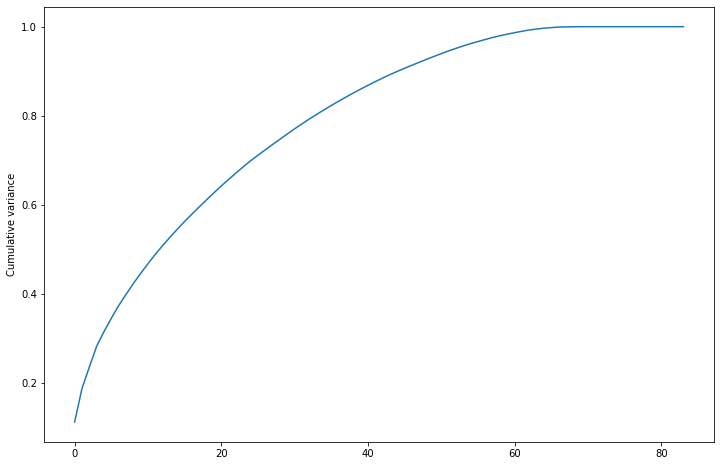

In [35]:
var_cum = np.cumsum(pca.explained_variance_ratio_)
fig = plt.figure(figsize=[12,8])
plt.plot(var_cum)
plt.ylabel('Cumulative variance')

In [36]:
#Perform PCA using 55 features

In [37]:
from sklearn.decomposition import IncrementalPCA

In [38]:
inc_pca = IncrementalPCA(n_components=55)
pca_train_df = inc_pca.fit_transform(X_train)
pca_test_df = inc_pca.transform(X_test)
print(pca_train_df.shape, pca_test_df.shape)

(48427, 55) (12107, 55)


In [39]:
cormat = np.corrcoef(pca_train_df.transpose())

### Prediction

#### Logistic Regression

In [40]:
log_reg = LogisticRegression()
log_model = log_reg.fit(pca_train_df, y_train)
y_pred = log_model.predict(pca_test_df)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('ROC AUC:', roc_auc_score(y_test, y_pred))

Accuracy: 0.806558189477162
ROC AUC: 0.8045338882192116


In [41]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.68      0.78      5952
           1       0.75      0.93      0.83      6155

    accuracy                           0.81     12107
   macro avg       0.83      0.80      0.80     12107
weighted avg       0.82      0.81      0.80     12107



#### XGBoost Classification

In [42]:
xgb_cl = XGBClassifier()
xgb_model_cl = xgb_cl.fit(pca_train_df, y_train)
y_pred = xgb_model_cl.predict(pca_test_df)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('ROC AUC:', roc_auc_score(y_test, y_pred))

Accuracy: 0.9162467993722639
ROC AUC: 0.915827049649293


In [43]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.89      0.91      5952
           1       0.90      0.94      0.92      6155

    accuracy                           0.92     12107
   macro avg       0.92      0.92      0.92     12107
weighted avg       0.92      0.92      0.92     12107



# Random Forest Classifier

In [44]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=42, n_estimators=10, max_depth=3)
rf_cl = rf.fit(pca_train_df, y_train)
y_pred =rf.predict(pca_test_df)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('ROC AUC:', roc_auc_score(y_test, y_pred))

Accuracy: 0.7850830098290246
ROC AUC: 0.7849366827389219


In [45]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.78      0.78      5952
           1       0.79      0.79      0.79      6155

    accuracy                           0.79     12107
   macro avg       0.79      0.78      0.78     12107
weighted avg       0.79      0.79      0.79     12107



### Using Hyperparameter tuning with PCA

In [46]:
classifier_rf = RandomForestClassifier(random_state=42, n_jobs=-1)

In [47]:
# Create the parameter grid based on the results of random search 
params = {
    'max_depth': [1, 2, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'max_features': [2,3,4],
    'n_estimators': [10, 30, 50, 100, 200]
}

In [48]:
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=classifier_rf, param_grid=params, 
                          cv=4, n_jobs=-1, verbose=1, scoring = "accuracy")

In [49]:
%%time
grid_search.fit(pca_train_df, y_train)

Fitting 4 folds for each of 375 candidates, totalling 1500 fits


KeyboardInterrupt: 

In [50]:
score_df = pd.DataFrame(grid_search.cv_results_)
score_df.head()

AttributeError: 'GridSearchCV' object has no attribute 'cv_results_'

In [ ]:
score_df.nlargest(5,"mean_test_score")

In [ ]:
dt_best1=grid_search.best_estimator_

In [ ]:
print("Train Accuracy :", accuracy_score(y_train,dt_best1.predict(pca_train_df)))
print("Test Accuracy :", accuracy_score(y_test,dt_best1.predict(pca_test_df)))
   

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(y_test, grid_search.predict(pca_test_df)))

### AdaBoost With PCA

In [ ]:
adaboost=AdaBoostClassifier(n_estimators=200,random_state=1)

In [ ]:
adaboost.fit(pca_train_df,y_train)

In [ ]:
y_pred=adaboost.predict(pca_test_df)

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(y_test,y_pred))

### Random Forest Classifier Without pca

In [ ]:
def get_dt_graph(dt_classifier):
    dot_data = StringIO()
    export_graphviz(dt_classifier, out_file=dot_data, filled=True,rounded=True,
                    feature_names=X.columns, 
                    class_names=['Disease', "No Disease"])
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    return graph

In [ ]:
def evaluate_model(dt_classifier):
    print("Train Accuracy :", accuracy_score(y_train, dt_classifier.predict(X_train)))
   
    print("Test Accuracy :", accuracy_score(y_test, dt_classifier.predict(X_test)))
   

In [ ]:
###With hyperparameter tuning

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf = RandomForestClassifier(random_state=42, n_estimators=10, max_depth=3)

In [ ]:
rf.fit(X_train, y_train)

In [ ]:
rf.estimators_[0]

In [ ]:
sample_tree = rf.estimators_[4]

In [ ]:
evaluate_model(rf)

In [ ]:
### hyperparameter tuning without pca

In [ ]:
classifier_rf = RandomForestClassifier(random_state=42, n_jobs=-1)

In [ ]:
# Create the parameter grid based on the results of random search 
params = {
    'max_depth': [1, 2, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'max_features': [2,3,4],
    'n_estimators': [10, 30, 50, 100, 200]
}

In [ ]:
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=classifier_rf, param_grid=params, 
                          cv=4, n_jobs=-1, verbose=1, scoring = "accuracy")

In [ ]:
%%time
grid_search.fit(new_df,y)

In [ ]:
score_df = pd.DataFrame(grid_search.cv_results_)
score_df.head()

In [ ]:
score_df.nlargest(5,"mean_test_score")

In [ ]:
dt_best=grid_search.best_estimator_

In [ ]:
evaluate_model(dt_best)

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(y_test, grid_search.predict(X_test)))

# ADABOOST Without PCA

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(new_df, y, random_state=42, test_size=0.2)

In [ ]:
adaboost=AdaBoostClassifier(n_estimators=200,random_state=1)

In [ ]:
adaboost.fit(X_train,y_train)

In [ ]:
y_pred=adaboost.predict(X_test)

In [ ]:
print('Accuracy of the model is',accuracy_score(y_test,y_pred))

In [ ]:
print(classification_report(y_test, grid_search.predict(X_test)))

### Cross Validation

In [ ]:
# params = {
#     'n_estimators':[100,200, 500, 750],
#     'learning_rate':[0.01, 0.02, 0.05, 0.1, 0.25],
#     'min_child_weight':[1,5,7,10],
#     'gamma':[0.1, 0.5, 1, 1.5, 5],
#     'subsample':[0.6,0.8,1.0],
#     'colsample_bytree':[0.6,0.8,1.0],
#     'max_depth':[3,4,5,10,12]
# }

# folds = 5
# param_combo = 100
# random_search = RandomizedSearchCV(estimator=xgb_cl, param_distributions=params, n_jobs=-1, scoring='accuracy', cv=5, verbose=1, n_iter=30)
# random_search.fit(pca_train_df, y_train)

In [ ]:
# param_grid = [    
#     {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
#     'C' : np.logspace(-4, 4, 20),
#     'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
#     'max_iter' : [100,200,500, 1000]
#     }
# ]
# clf = GridSearchCV(log_reg, param_grid = param_grid, cv = 3, verbose=True, n_jobs=-1)
# clf_model = clf.fit(pca_train_df, y_train)

### Predict Solutions

In [ ]:
test_data =  pd.read_csv('test.csv')
for col in test_data.columns:
    print(col)

In [ ]:
for col in columns_70:
    print(col)

In [ ]:
if('churn_probability' in columns_70):
    columns_70.remove('churn_probability')
#columns_70.remove('churn_probability')
test_data = test_data[columns_70]

# Delete Date columns
date_col = []
for col in test_data.columns:
    if 'date' in col:
        date_col.append(col)
test_data.drop(columns=date_col, inplace=True)

#Fill MOU and other outgoing, incoming call null values with 0
test_data.fillna(0, inplace=True)

#find all the month columns
month_col = []
distinct_features = []
for col in test_data.columns:
    if '6' in col or '7' in col or '8' in col:
        month_col.append(col)
        col = col.split('_')[:-1]
        col = '_'.join(col)
        distinct_features.append(col)

# Find the avg and difference for all these columns
for feature in set(distinct_features):
    test_data[feature+'_avg'] = (test_data[feature+'_6'] + test_data[feature+'_7'])/2
    test_data[feature+'_diff'] = test_data[feature+'_avg'] - test_data[feature+'_8']
    test_data.drop(columns=[feature+'_6', feature+'_7', feature+'_8'], inplace=True)

test_data['vbc_3g_avg'] = test_data['jun_vbc_3g'] + test_data['jul_vbc_3g']
test_data['vbc_3g_avg'] = test_data['vbc_3g_avg']/2
test_data['vbc_3g_diff'] = test_data['vbc_3g_avg'] - test_data['aug_vbc_3g']
test_data.drop(columns=['aug_vbc_3g', 'jun_vbc_3g', 'jul_vbc_3g'], inplace=True)

#delete columns with 0 variance
test_data.drop(columns=cols_with_std_0, inplace=True)

# print(test_data.shape)

test_data_bkp = test_data.copy()

# test_data = scaler.transform(test_data)
# test_data = inc_pca.transform(test_data)
# y_result = log_model.predict(test_data)

# y_result = res.predict(sm.add_constant(test_data)).values.reshape(-1)
# y_result = [1 if i>=0.55 else 0 for i in y_result]
xgbm_model = xgbm.fit(X_train, y_train)
y_result = xgbm_model.predict(test_data)
#y_result=adaboost.predict(test_data)
print(y_result)
##print('Accuracy of the model is',accuracy_score(y_result,y_pred))
##accuracy = accuracy_score(y_test,y_result)
##print(accuracy)
test_data_bkp['churn_probability'] = y_result
test_solution = test_data_bkp.loc[:, ['id', 'churn_probability']]
test_solution.to_csv('test_data_solution.csv', index=False)